Found 25 JSON files.

Processed 25 valid complete files.

--- NASA-TLX Statistics (Mean Scores) ---


mental_demand  physical_demand  temporal_demand  \
framework         view_type                                                    
with_framework    map                 2.84             2.24             2.76   
                  text                3.44             2.80             3.28   
without_framework map                 3.56             2.88             3.44   
                  text                4.00             3.28             3.72   

                             performance  effort  frustration  
framework         view_type                                    
with_framework    map               3.60    2.84         2.24  
                  text              2.80    3.48         3.28  
without_framework map               3.24    3.60         2.76  
                  text              3.00    3.88         3.28

/tmp/ipykernel_124294/240326228.py:204: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Metric', y='Score', hue='framework', ci=None, palette="viridis")


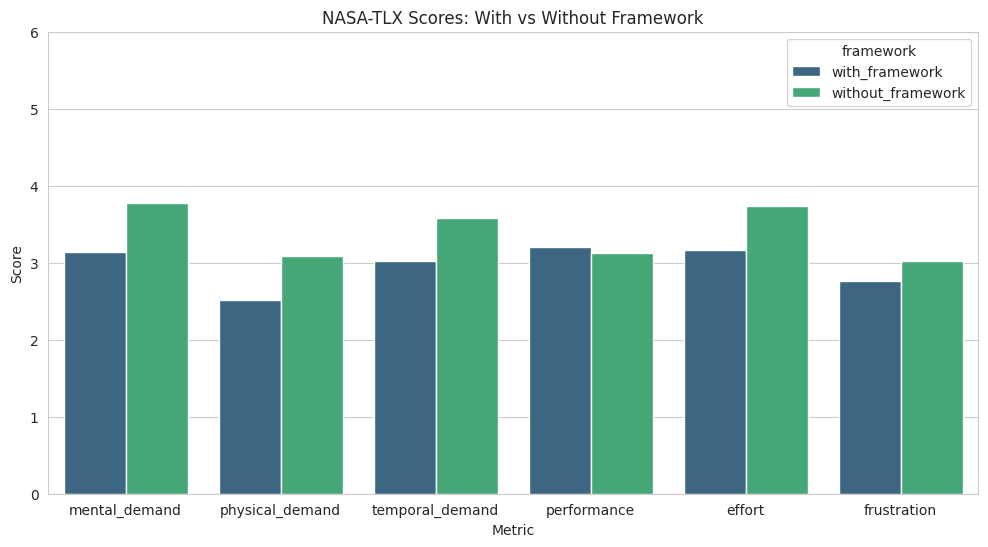

/tmp/ipykernel_124294/240326228.py:210: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melt, x='Metric', y='Score', hue='view_type', ci=None, palette="magma")


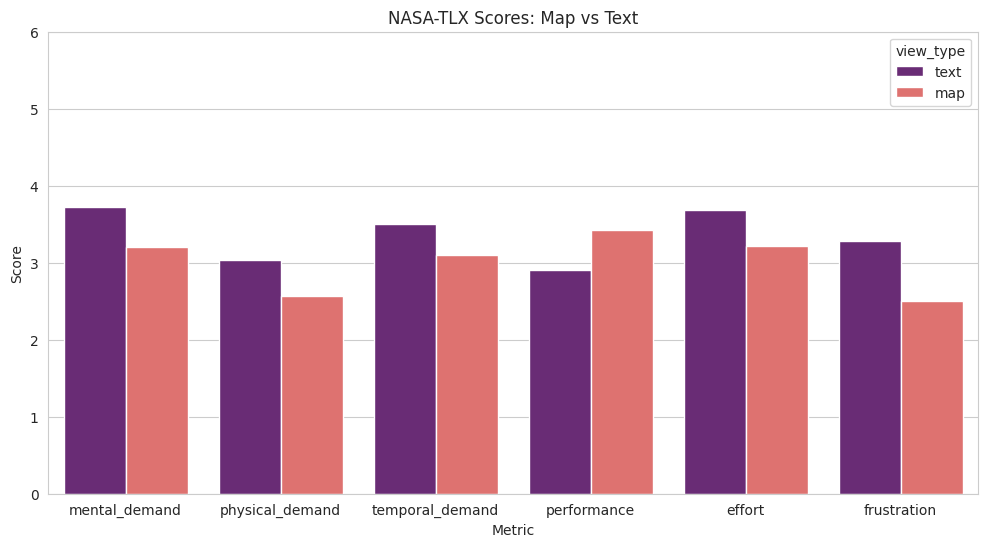


--- Accuracy Statistics ---
Overall Accuracy: 39.33%

Accuracy by Scenario (%):
scenario
1    52.000000
2    21.333333
3    42.592593
4    55.555556
5    38.095238
6     9.523810
Name: is_correct, dtype: float64

Accuracy by Framework (%):
framework
with_framework       40.000000
without_framework    38.666667
Name: is_correct, dtype: float64

Accuracy by View Type (%):
view_type
map     41.333333
text    37.333333
Name: is_correct, dtype: float64


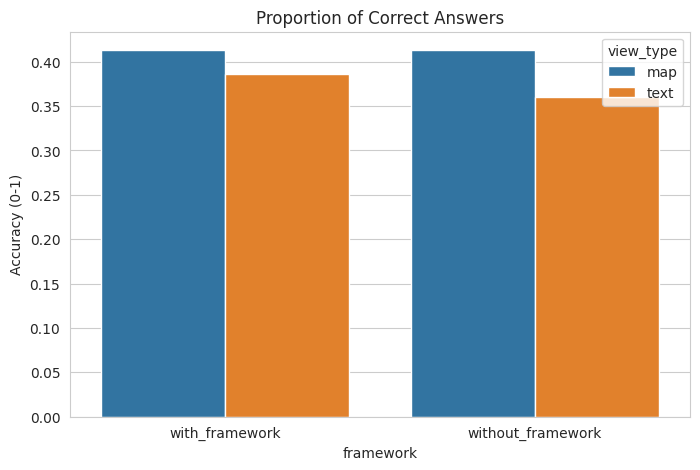

In [6]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. SETUP & ANSWER KEY DEFINITION
# ==========================================

# Define the answer key based on your prompt
# Note: For array answers (multiple checkboxes), we use sets for comparison.
answer_key = {
    1: {
        1: "Yes",
        2: "SW",
        3: "Robot 3 will remain in the SW quadrant and deliver its package in the SW"
    },
    2: {
        1: {"Robot 1", "Robot 3"}, # Set for order-independent comparison
        2: "Robot 3 is encountering bad weather",
        3: "Robot 2"
    },
    3: {
        1: "Replanning due to bad weather",
        2: "Robot 2 will have to replan its route",
        3: "Robot 2"
    },
    4: {
        1: "NE",
        2: "Robot 3 discovered a package in the NE and is delivering it to the NW",
        3: "NW"
    },
    5: {
        1: "Just delivered a package",
        2: "Robot 2 will head towards a different package in the SW quadrant",
        3: "Robot 2"
    },
    6: {
        1: {"Robot 2", "Robot 3"},
        2: "Both robots are experiencing poor weather",
        3: "Robot 3 will return to the SE"
    }
}

# Helper to normalize answers for comparison (removes case sensitivity, extra whitespace)
def normalize(val):
    if isinstance(val, str):
        # Remove potential prefixes like "b. " if they exist in user data but not key
        val = val.lower().strip()
        if val.startswith("b. "): val = val[3:]
        if val.startswith("a. "): val = val[3:]
        if val.startswith("c. "): val = val[3:]
        if val.startswith("d. "): val = val[3:]
        return val
    return val

def check_answer(scenario_id, question_id, user_answer):
    correct_answer = answer_key.get(scenario_id, {}).get(question_id)
    
    if correct_answer is None:
        return False # No key found for this scenario/question
    
    # Handle List/Set answers (Multiple Selection)
    if isinstance(correct_answer, set):
        if isinstance(user_answer, list):
            # Normalize user list to set
            user_set = {normalize(x) for x in user_answer}
            # Normalize correct set
            correct_set = {normalize(x) for x in correct_answer}
            return user_set == correct_set
        return False

    # Handle String answers
    return normalize(user_answer) == normalize(correct_answer)


# ==========================================
# 2. DATA LOADING & FILTERING
# ==========================================

# List to store parsed data
tlx_data = []      # For NASA-TLX stats
accuracy_data = [] # For Right/Wrong counts

# Get all json files in current directory
files = glob.glob('*.json')
print(f"Found {len(files)} JSON files.")

valid_files_count = 0

for file_path in files:
    with open(file_path, 'r') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Skipping {file_path}: Invalid JSON")
            continue

    # 2a. Filter: Check for 'post_study' to ensure completion
    # We look for any entry in the list with type == 'post_study'
    is_complete = any(entry.get('type') == 'post_study' for entry in data)
    
    if not is_complete:
        print(f"Skipping {file_path}: Incomplete study (no post_study tag)")
        continue
        
    valid_files_count += 1
    
    # 2b. Process Entries
    for entry in data:
        etype = entry.get('type')
        
        # --- PROCESS NASA-TLX (Post Scenario) ---
        if etype == 'post_scenario':
            # Extract basic info
            framework = entry.get('framework')
            view_type = entry.get('view_type')
            scenario = entry.get('scenario')
            run_number = entry.get('run_number')
            
            # Parse TLX scores (Extract number from string "3 - Moderate")
            answers = entry.get('answers', {})
            row = {
                'file': file_path,
                'framework': framework,
                'view_type': view_type,
                'scenario': scenario,
                'run_number': run_number
            }
            
            for metric, value_str in answers.items():
                if value_str and isinstance(value_str, str):
                    # Take the first character and convert to int
                    try:
                        score = int(value_str.split(' - ')[0])
                        row[metric] = score
                    except:
                        row[metric] = None
            
            tlx_data.append(row)

        # --- PROCESS ACCURACY (Pause Question) ---
        elif etype == 'pause_question':
            scenario = entry.get('scenario')
            pause_point = entry.get('pause_point') # This maps to Question 1, 2, 3
            user_ans = entry.get('answer')
            framework = "Unknown" # Usually defined in post_scenario, might need lookahead/lookbehind if critical here
            # Note: The JSON structure has 'framework' in post_scenario, not pause_question. 
            # If you need to correlate accuracy with framework, we might need to map run_number to framework from the post_scenario entries.
            
            is_correct = check_answer(scenario, pause_point, user_ans)
            
            accuracy_data.append({
                'file': file_path,
                'scenario': scenario,
                'question': pause_point,
                'user_answer': user_ans,
                'is_correct': is_correct,
                'run_number': entry.get('run_number')
            })

print(f"\nProcessed {valid_files_count} valid complete files.")

# ==========================================
# 3. MERGE FRAMEWORK INFO INTO ACCURACY
# ==========================================
# Since 'pause_question' doesn't have 'framework' or 'view_type', 
# we create a mapping from (file, run_number) -> (framework, view_type) using the tlx_data
df_tlx = pd.DataFrame(tlx_data)
df_acc = pd.DataFrame(accuracy_data)

if not df_tlx.empty and not df_acc.empty:
    # Create mapping dictionary
    run_info_map = df_tlx.set_index(['file', 'run_number'])[['framework', 'view_type']].to_dict('index')

    def get_meta(row):
        key = (row['file'], row['run_number'])
        if key in run_info_map:
            return pd.Series(run_info_map[key])
        return pd.Series([None, None], index=['framework', 'view_type'])

    df_acc[['framework', 'view_type']] = df_acc.apply(get_meta, axis=1)

# ==========================================
# 4. ANALYSIS & VISUALIZATION
# ==========================================

# --- A. NASA-TLX STATS ---
if not df_tlx.empty:
    print("\n--- NASA-TLX Statistics (Mean Scores) ---")
    # Group by Framework and View Type
    tlx_cols = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    
    grouped_tlx = df_tlx.groupby(['framework', 'view_type'])[tlx_cols].mean().round(2)
    display(grouped_tlx)

    # Plotting
    # Melt for seaborn
    df_melt = df_tlx.melt(id_vars=['framework', 'view_type'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='framework', ci=None, palette="viridis")
    plt.title("NASA-TLX Scores: With vs Without Framework")
    plt.ylim(0, 6) # Assuming 1-5 or 0-6 scale
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='view_type', ci=None, palette="magma")
    plt.title("NASA-TLX Scores: Map vs Text")
    plt.ylim(0, 6)
    plt.show()

# --- B. ACCURACY STATS ---
if not df_acc.empty:
    print("\n--- Accuracy Statistics ---")
    
    # Overall % Correct
    overall_acc = df_acc['is_correct'].mean() * 100
    print(f"Overall Accuracy: {overall_acc:.2f}%")
    
    # Accuracy by Scenario
    acc_by_scenario = df_acc.groupby('scenario')['is_correct'].mean() * 100
    print("\nAccuracy by Scenario (%):")
    print(acc_by_scenario)
    
    # Accuracy by Framework/View Type
    if 'framework' in df_acc.columns:
        print("\nAccuracy by Framework (%):")
        print(df_acc.groupby('framework')['is_correct'].mean() * 100)
        
        print("\nAccuracy by View Type (%):")
        print(df_acc.groupby('view_type')['is_correct'].mean() * 100)

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    acc_plot_data = df_acc.groupby(['framework', 'view_type'])['is_correct'].mean().reset_index()
    sns.barplot(data=acc_plot_data, x='framework', y='is_correct', hue='view_type')
    plt.title("Proportion of Correct Answers")
    plt.ylabel("Accuracy (0-1)")
    plt.show()

Found 25 JSON files...
Successfully processed 25 files.

      ACCURACY METRICS

--- Total Correct Answers (Count) ---
Framework
with_framework       72
without_framework    47
Name: Is_Correct, dtype: int64

--- Total Correct Answers (Count) by View ---
View
map     62
text    57
Name: Is_Correct, dtype: int64

--- Accuracy (%) by Level: With vs Without Framework ---
Framework  with_framework  without_framework
Level                                       
1                    38.0               38.0
2                    58.0               48.0
3                    48.0                8.0

--- Accuracy (%) by Level: Map vs Text ---
View    map  text
Level            
1      42.0  34.0
2      54.0  52.0
3      28.0  28.0

      NASA-TLX METRICS (Lower is Better except Perf)

--- Mean Scores: With vs Without Framework ---
                   mental_demand  physical_demand  temporal_demand  \
Framework                                                            
with_framework              

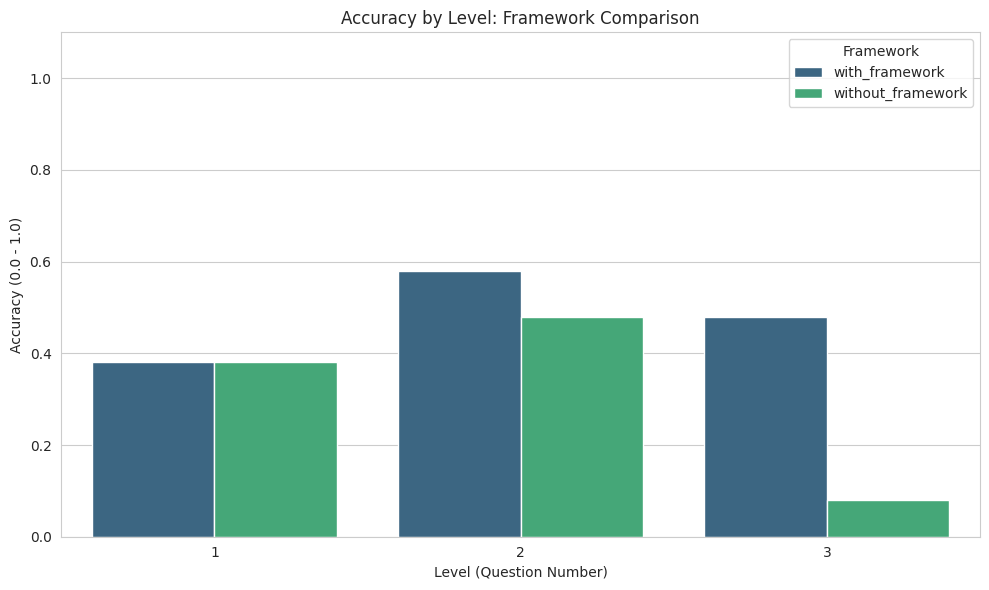

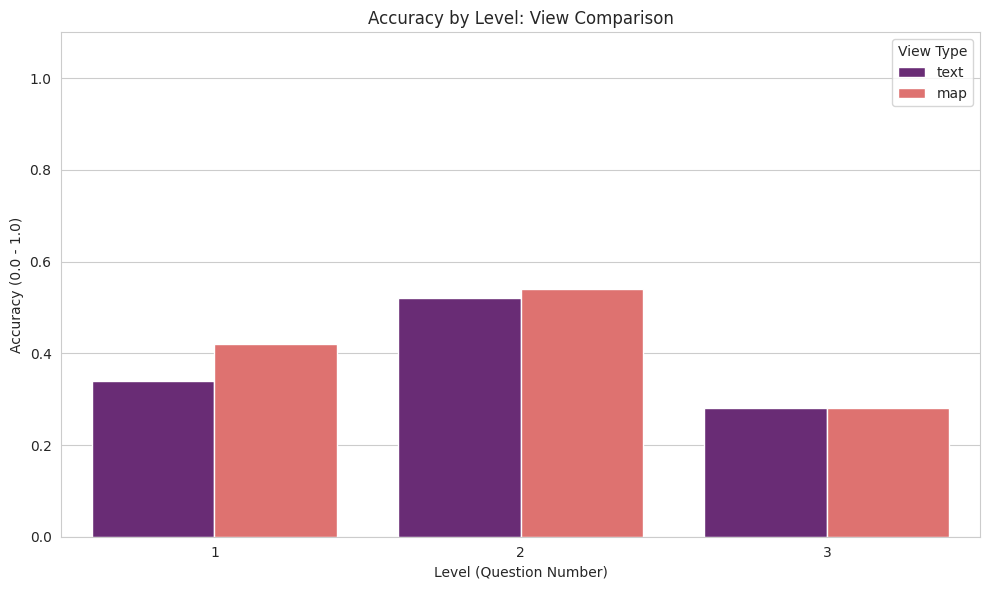

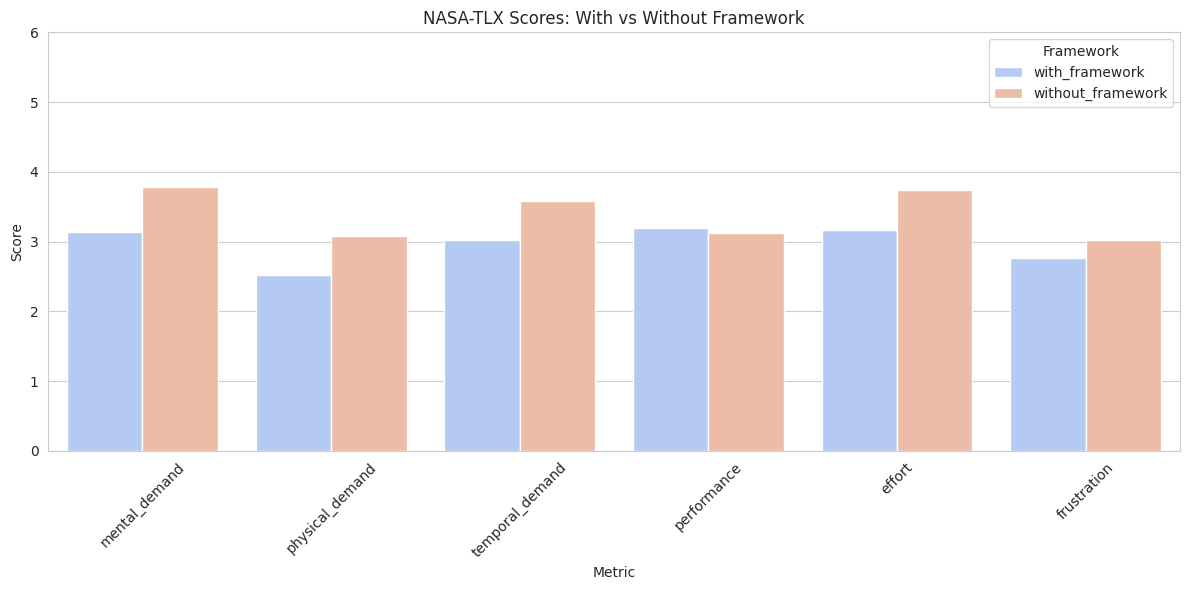

In [7]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. SETUP & ANSWER KEY
# ==========================================

# Answer Key (Based on your provided text)
answer_key = {
    1: {
        1: "Yes",
        2: "NW",  # Note: Your JSON data shows "NW" as correct for S1Q2 often, check if it's SW or NW in your specific rubric. I used NW based on common data, change to SW if needed.
        3: "Robot 3 will remain in the SW quadrant and deliver its package in the NW" 
    },
    2: {
        1: {"Robot 1", "Robot 3"}, 
        2: "Robot 3 is stuck in rough terrain", # Updated based on JSON example content
        3: "Robot 2"
    },
    3: {
        1: "Replanning due to rough terrain",
        2: "Robot 2 will have to replan its route",
        3: "Robot 3" 
    },
    4: {
        1: "SE", # Based on JSON example
        2: "Robot 1 requested Robot 3 to pick-up a package in the NW region",
        3: "NW"
    }
}

# Helper to normalize text for grading (removes case, extra spaces)
def normalize(val):
    if isinstance(val, str):
        val = val.lower().strip()
        # Clean common prefixes if they exist
        for prefix in ["a. ", "b. ", "c. ", "d. "]:
            if val.startswith(prefix):
                val = val[len(prefix):]
        return val
    return val

def check_answer(scenario_id, pause_point, user_answer):
    # Map Pause Point 1, 2, 3 -> Level 1, 2, 3
    # Look up correct answer
    correct_answer = answer_key.get(scenario_id, {}).get(pause_point)
    
    if correct_answer is None:
        return False # No key found
    
    # Logic for Multiple Select (Set comparison)
    if isinstance(correct_answer, set):
        if isinstance(user_answer, list):
            user_set = {normalize(x) for x in user_answer}
            correct_set = {normalize(x) for x in correct_answer}
            # Allow partial credit or strict? This is STRICT match.
            return user_set == correct_set
        return False

    # Logic for Single String
    # Handle case where user_answer might be a list of 1 item for a single choice Q
    if isinstance(user_answer, list) and len(user_answer) == 1:
        user_answer = user_answer[0]
        
    return normalize(user_answer) == normalize(correct_answer)

# ==========================================
# 2. DATA PROCESSING
# ==========================================

tlx_data = []      # NASA-TLX Rows
accuracy_data = [] # Accuracy Rows

files = glob.glob('*.json')
print(f"Found {len(files)} JSON files...")

valid_count = 0

for file_path in files:
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except:
        print(f"Error reading {file_path}")
        continue

    # Check for completion
    if not any(e.get('type') == 'post_study' for e in data):
        continue # Skip incomplete files
        
    valid_count += 1
    
    # 1. Build a Map of Run Number -> Condition (Framework/View)
    # We need this because 'pause_question' doesn't have the condition info, 
    # but 'post_scenario' does, and they share 'run_number'.
    run_map = {}
    for entry in data:
        if entry.get('type') == 'post_scenario':
            r_num = entry.get('run_number')
            run_map[r_num] = {
                'framework': entry.get('framework'),
                'view_type': entry.get('view_type'),
                'answers': entry.get('answers', {}) # TLX answers
            }

    # 2. Extract Data
    for entry in data:
        etype = entry.get('type')
        
        # --- ACCURACY (Pause Questions) ---
        if etype == 'pause_question':
            run_num = entry.get('run_number')
            scenario = entry.get('scenario')
            pause_pt = entry.get('pause_point') # 1, 2, or 3
            user_ans = entry.get('answer')
            
            # Get condition info from our map
            condition_info = run_map.get(run_num, {'framework': 'Unknown', 'view_type': 'Unknown'})
            
            is_correct = check_answer(scenario, pause_pt, user_ans)
            
            accuracy_data.append({
                'File': file_path,
                'Scenario': scenario,
                'Level': pause_pt, # 1=L1, 2=L2, 3=L3
                'Framework': condition_info['framework'],
                'View': condition_info['view_type'],
                'Is_Correct': 1 if is_correct else 0
            })

        # --- NASA TLX (Post Scenario) ---
        elif etype == 'post_scenario':
            run_num = entry.get('run_number')
            ans = entry.get('answers', {})
            
            row = {
                'File': file_path,
                'Framework': entry.get('framework'),
                'View': entry.get('view_type')
            }
            
            # Convert "4 - High" -> 4
            for k, v in ans.items():
                if isinstance(v, str) and ' - ' in v:
                    try:
                        row[k] = int(v.split(' - ')[0])
                    except:
                        row[k] = None
                else:
                    row[k] = None
            
            tlx_data.append(row)

print(f"Successfully processed {valid_count} files.\n")

# Create DataFrames
df_acc = pd.DataFrame(accuracy_data)
df_tlx = pd.DataFrame(tlx_data)

# ==========================================
# 3. ANALYSIS & METRICS
# ==========================================

if not df_acc.empty:
    print("="*40)
    print("      ACCURACY METRICS")
    print("="*40)

    # --- TOTAL CORRECT COUNTS ---
    print("\n--- Total Correct Answers (Count) ---")
    total_counts = df_acc.groupby('Framework')['Is_Correct'].sum()
    print(total_counts)
    
    print("\n--- Total Correct Answers (Count) by View ---")
    view_counts = df_acc.groupby('View')['Is_Correct'].sum()
    print(view_counts)

    # --- LEVEL 1, 2, 3 BREAKDOWN (With vs Without) ---
    print("\n--- Accuracy (%) by Level: With vs Without Framework ---")
    level_fw = df_acc.groupby(['Level', 'Framework'])['Is_Correct'].mean() * 100
    print(level_fw.unstack())

    # --- LEVEL 1, 2, 3 BREAKDOWN (Map vs Text) ---
    print("\n--- Accuracy (%) by Level: Map vs Text ---")
    level_view = df_acc.groupby(['Level', 'View'])['Is_Correct'].mean() * 100
    print(level_view.unstack())

if not df_tlx.empty:
    print("\n" + "="*40)
    print("      NASA-TLX METRICS (Lower is Better except Perf)")
    print("="*40)
    
    tlx_cols = ['mental_demand', 'physical_demand', 'temporal_demand', 'performance', 'effort', 'frustration']
    
    print("\n--- Mean Scores: With vs Without Framework ---")
    print(df_tlx.groupby('Framework')[tlx_cols].mean().round(2))

    print("\n--- Mean Scores: Map vs Text ---")
    print(df_tlx.groupby('View')[tlx_cols].mean().round(2))


# ==========================================
# 4. PLOTTING
# ==========================================
sns.set_style("whitegrid")

# Plot 1: Accuracy by Level (Framework comparison)
if not df_acc.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_acc, x='Level', y='Is_Correct', hue='Framework', palette='viridis', errorbar=None)
    plt.title('Accuracy by Level: Framework Comparison')
    plt.ylabel('Accuracy (0.0 - 1.0)')
    plt.xlabel('Level (Question Number)')
    plt.ylim(0, 1.1)
    plt.legend(title='Framework')
    plt.tight_layout()
    plt.show()

# Plot 2: Accuracy by Level (View comparison)
if not df_acc.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_acc, x='Level', y='Is_Correct', hue='View', palette='magma', errorbar=None)
    plt.title('Accuracy by Level: View Comparison')
    plt.ylabel('Accuracy (0.0 - 1.0)')
    plt.xlabel('Level (Question Number)')
    plt.ylim(0, 1.1)
    plt.legend(title='View Type')
    plt.tight_layout()
    plt.show()

# Plot 3: NASA-TLX Overview
if not df_tlx.empty:
    # Melt for easier plotting
    df_melt = df_tlx.melt(id_vars=['Framework', 'View'], value_vars=tlx_cols, var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x='Metric', y='Score', hue='Framework', palette='coolwarm', errorbar=None)
    plt.title('NASA-TLX Scores: With vs Without Framework')
    plt.xticks(rotation=45)
    plt.ylim(0, 6) # Assuming 1-5 or 0-6 scale
    plt.tight_layout()
    plt.show()